This notebook is all about coming up with ways to asses how good a job PyVBMC does. 

To start, we'll state the differential equation of interest, get integration working for that equation, and run a PyVBMC optimize routine on it.


The differential equation:

$$\ddot{x} = -x -ax^b$$

generalized to deal with all values of b:

$$\ddot{x} = -x - sign(x)a|x|^b$$

$0\leq a\leq0.5$

 $1\leq b \leq 5$

In [1]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

In [2]:
def diffyqs(X, t, a,b):
    x, vx = X[0], X[1]
    dx = vx
    dv = -x - np.sign(x) * a * np.abs(x)**b
    return [dx, dv]

initial_condition = [0.0, 3.5]
t = np.arange(0,10,0.05)

a_true = 0.2 
b_true = 4.0
sol = odeint(diffyqs, initial_condition, t, args=(a_true,b_true))
x_true = sol[:,1]

a_min = 0.0
a_max = 0.5
b_min = 1.0
b_max = 5.0

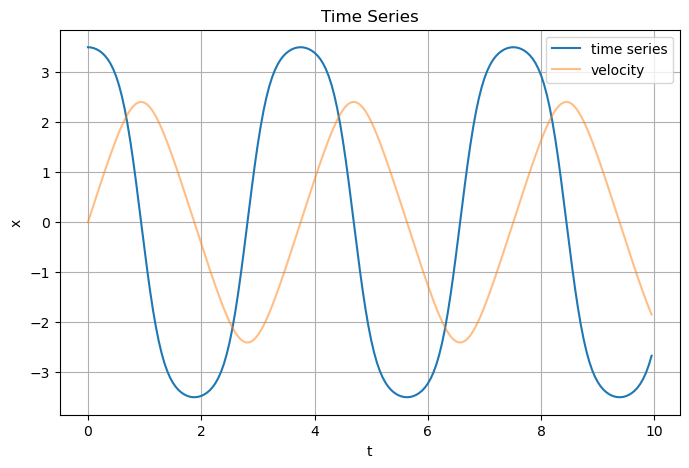

In [3]:
def plot_ts(t,ts,v, mode = 0):
    plt.figure(figsize=(8,5))
    if mode == 0:
        plt.plot(t,ts)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.grid()
        plt.show()
    else:
        plt.plot(t,ts, label = 'time series')
        plt.plot(t,v, label = 'velocity', alpha = 0.5)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.legend()
        plt.grid()
        plt.show()

plot_ts(t,sol[:, 1],sol[:, 0],1)

In [4]:
def log_likelihood(theta):
    a,b = theta
    #a_true = 0.2 
    #b_true = 4.0
    #sol = odeint(diffyqs, initial_condition, t, args=(a_true,b_true))
    #x_true = sol[:,1]
    sol = odeint(diffyqs, initial_condition, t, args=(a,b)) # get solution of ODE with current choice of params
    return -np.sum((sol[:,1] - x_true)**2) # normal distribution sorta

In [5]:
D = 2  # 2-D since there are 2 params we're estimating

LB = np.full((1, D), a_min)  # Lower bounds
LB[0][1] = b_min
UB = np.full((1, D), a_max)  # Upper bounds
UB[0][1] = b_max

PLB = np.copy(LB) + 0.05
PUB = np.copy(UB) - 0.05

x0 = np.full((1, D), a_true+0.1) # starting point for inference   # 1.5 * np.ones((1, D))
x0[0][1] = b_true + 0.1

print(LB,PLB,PUB,UB,'x0:',x0)

[[0. 1.]] [[0.05 1.05]] [[0.45 4.95]] [[0.5 5. ]] x0: [[0.3 4.1]]


In [6]:
prior = SplineTrapezoidal(LB, PLB, PUB, UB)
#prior = [scs.norm(loc = 0.3,scale = 0.3),scs.norm(loc = 3.9,scale = 0.3)]
options = {
    "display": "off"
}

In [7]:
def old_euclidean_metric(vp,truth_array, n_samples = int(2e6),original = False): 

    Xs, _ = vp.sample(n_samples) # sample vp
    scaler = StandardScaler() # create scaler (don't bother centering)
    scaler.fit(Xs)                     # fit scaler to samples
    scaled_data = scaler.transform(Xs) # scale samples
    mean = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()]) # compute mean of samples
    truth_scaled = scaler.transform(truth_array) # scale true data
    if original:
        return np.linalg.norm(scaler.inverse_transform(mean-truth_scaled))
    else:
        return np.linalg.norm(mean-truth_scaled)

In [8]:
def euclidean_metric(vp,truth_array, n_samples = int(2e6),original = False): 
    """
    Returns a measure of how close the actual parameters are to the estimated parameters,
    computed by finding the euclidean distance between the mean of a large sample of the 
    varaitional posterior and the true values of the parameters.

    vp: varational posterior from PyVBMC
    truth_array: numpy array of the true values of the parameters (must be in the same order as the vp returns!)

    set original to true to respect the original distances
    """
    Xs, _ = vp.sample(n_samples) # sample vp
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(Xs)                     # fit scaler to samples
    scaled_data = scaler.transform(Xs) # scale samples
    mean = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()]) # compute mean of samples
    truth_scaled = scaler.transform(truth_array) # scale true data
    if original:
        return np.linalg.norm(scaler.inverse_transform(mean-truth_scaled))
    else:
        return np.linalg.norm(mean-truth_scaled)

# call the function on our current example
# print(euclidean_metric(vp,np.array([[a,b]])),euclidean_metric(vp,np.array([[a,b]]),original =True),old_euclidean_metric(vp,np.array([[a,b]])))

In [9]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options) # initialize VMBC object
vp, results = vbmc.optimize(); # do optimization (might take a while)

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -7.641 +/-0.001.


In [95]:
metric_list = []
np.random.seed(5)
vbmc0 = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options) 
np.random.seed(5)
vbmc1 = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options) 
np.random.seed(5)
vbmc2 = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options) 
np.random.seed(5)
vp0, results0 = vbmc0.optimize();
np.random.seed(5)
vp1, results1 = vbmc1.optimize();
np.random.seed(5)
vp2, results2 = vbmc2.optimize();
np.random.seed(5)
metric_list.append(euclidean_metric(vp0,np.array([[a_true,b_true]])))
np.random.seed(5)
metric_list.append(euclidean_metric(vp1,np.array([[a_true,b_true]])))
np.random.seed(5)
metric_list.append(euclidean_metric(vp2,np.array([[a_true,b_true]])))

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.502 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.502 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.502 +/-0.001.


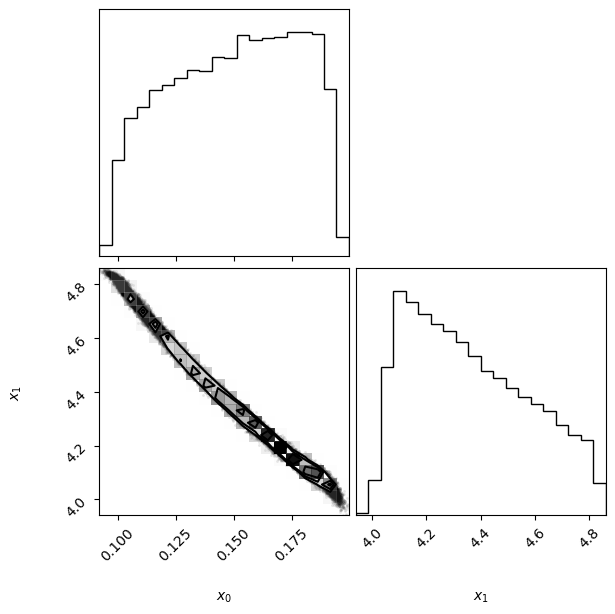

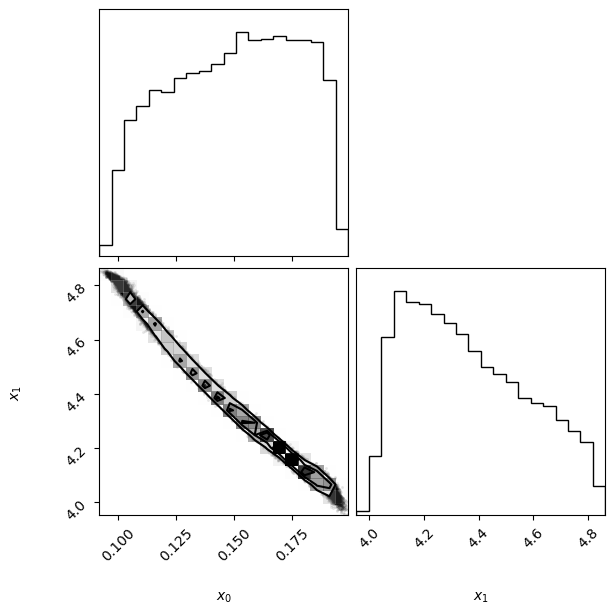

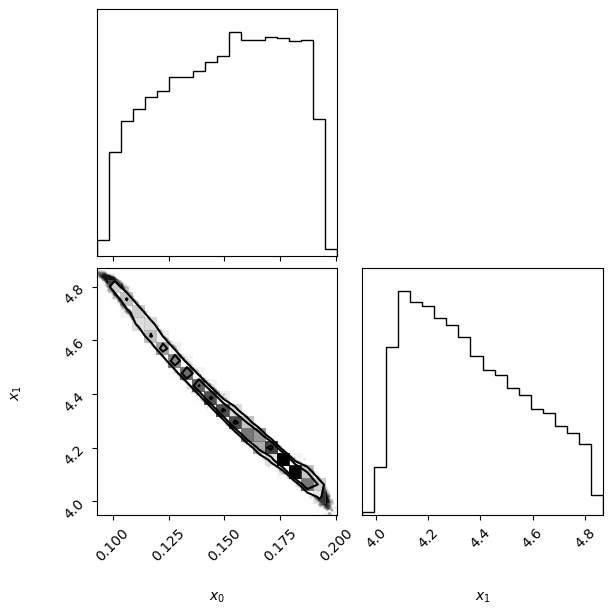

In [98]:
vp0.plot();
vp1.plot();
vp2.plot();

In [10]:
Xs, _ = vp.sample(int(1e5)) # sample vp
pdf_mode = scs.mode(Xs,keepdims = True)
print(pdf_mode[0])
vp.moments()

[[0.08344556 4.4421999 ]]


array([[0.11045205, 4.70629666]])

In [41]:
import scipy.stats as scs
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

# pdf_simple = lambda x,y: vp.pdf(np.array([[y,x]]))

# def CI_2D(vp,pdf,true_value,step = 0.05,n_samples = int(5e5)):
#     # do sampling, take mode of samples
#     Xs, _ = vp.sample(n_samples) # sample vp
#     pdf_mode = scs.mode(Xs,keepdims = True)[0]
#     a0,b0 = pdf_mode[0][0] - step, pdf_mode[0][0] + step
#     a1,b1 = pdf_mode[0][1] - step, pdf_mode[0][1] + step
#     #I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
#     def check_if_in_CI(true_value,a0,b0,a1,b1):
#         if a0 <= true_value[0] and true_value[0] <= b0 \
#             and a1 <= true_value[1] and true_value[1] <= b1:
#             return False
#         else:
#             return True
#     iter = 0
#     while check_if_in_CI(true_value,a0,b0,a1,b1):
#         I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
#         a0 -= step
#         b0 += step
#         a1 -= step
#         b1 += step
#         print("iter:",iter,"I", I )

#         iter += 1
#     return I

# print("CI:",CI_2D(vp,pdf_simple,[4,0.2],0.1))


pdf_simple = lambda x,y: vp.pdf(np.array([[y,x]]))
def CI_2D(vp,pdf,true_value,step = 0.05,n_samples = int(5e5)):
    # do sampling, take mode of samples
    Xs, _ = vp.sample(n_samples) # sample vp
    pdf_mode = scs.mode(Xs,keepdims = True)[0]
    print("mode:",pdf_mode)
    print("expectation",vp.moments())
    a0,b0 = pdf_mode[0][0] - step, pdf_mode[0][0] + step
    a1,b1 = pdf_mode[0][1] - step, pdf_mode[0][1] + step
    print("a0, b0:", a0, b0, "a1, b1:", a1, b1)
    I = 0
    #I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
    print(I)
    print(true_value)
    def check_if_in_CI(true_value,a0,b0,a1,b1):
        # if a0 <= true_value[0] and true_value[0] <= b0 \
        #     and a1 <= true_value[1] and true_value[1] <= b1:

        if a0 <= true_value[0] <= b0 and a1 <= true_value[1] <= b1:
            print("hit")
            return False
        else:
            return True
    iter = 0
    while check_if_in_CI(true_value,a0,b0,a1,b1):
        
        a0 -= step
        b0 += step
        a1 -= step
        b1 += step
        #print("iter",iter )
        iter += 1
        #print(I)
    I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
    return I
print("CI:",CI_2D(vp,pdf_simple,[0.2,2.0],0.1))


mode: [[0.43044223 1.98357072]]
expectation [[0.485751   2.12138954]]
a0, b0: 0.3304422296040501 0.5304422296040501 a1, b1: 1.8835707245116773 2.0835707245116772
0
[0.2, 2.0]
hit
CI: 0.9999999999999458


In [ ]:
def CI_1D(pdf,true_value,step):
    a,b = pdf_mode - step, pdf_mode + step
    I = 0
    def check_if_in_CI(true_value,a,b):
        if a <= true_value and true_value <= b:
            return False
        else:
            return True
    while check_if_in_CI(true_value,a,b):
        I = integrate(pdf,a,b)
        a -= step
        b += step
    return I

# Heatmap data with euclidean metric

In [20]:
N = 2
grid = np.zeros((N,N))
bad_grid = np.copy(grid)
old_grid = np.copy(grid)
solutions = []
pairs = []
for i,a in enumerate(np.linspace(a_min,a_max,N)):     # a will be y axis in grid
    for j,b in enumerate(np.linspace(b_min,b_max,N)): # b will be x axis in grid
        sol_true = odeint(diffyqs, initial_condition, t, args=(a,b))
        x_true = sol_true[:,1]
        solutions.append(x_true)
        np.random.seed(5)
        vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
        np.random.seed(5)
        vp, results = vbmc.optimize();
        pairs.append([a,b])
        metric = euclidean_metric(vp,np.array([[a,b]]))
        grid[i,j] = metric
        bad_grid[i,j] = euclidean_metric(vp,np.array([[a,b]]), original = True)
        old_grid[i,j] = old_euclidean_metric(vp,np.array([[a,b]]))

#np.array(grid).tofile('metrics_grid.csv', sep = ',')
#np.array(metrics).tofile('metrics.csv', sep = ',')

c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.271 +/-0.001.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.271 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.394 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -2696.550 +/-0.001.


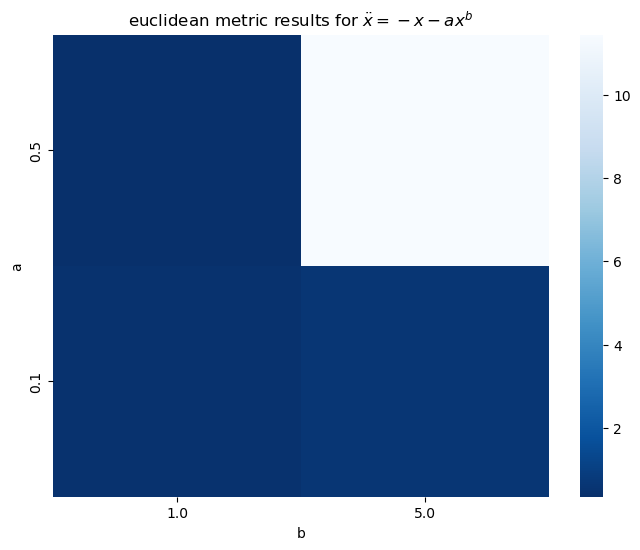

In [36]:
def heatmap_plotter(grid):
    colormap = sns.color_palette("Blues_r", as_cmap=True)
    plt.figure(figsize=(8,6))
    sns.heatmap(np.flip(grid, axis = 0),cmap = colormap)
    plt.title(r"euclidean metric results for $\ddot{x} = -x -ax^b$")
    plt.xlabel("b")
    plt.ylabel('a')
    plt.xticks(ticks = np.arange(N)+0.5, labels = np.around(np.linspace(b_min,b_max,N),2))
    plt.yticks(ticks = np.arange(N)+0.5, labels = np.around(np.linspace(a_max,a_min,N),2))
    plt.show()

heatmap_plotter(grid)

In [35]:
a_min = 0.1
a_max = 0.5
b_min = 1.0
b_max = 5.0

N = 2
grid1 = np.zeros((N,N))
bad_grid = np.copy(grid)
old_grid = np.copy(grid)
solutions = []
pairs = []
for i,a in enumerate(np.linspace(a_min,a_max,N)):     # a will be y axis in grid
    for j,b in enumerate(np.linspace(b_min,b_max,N)): # b will be x axis in grid
        sol_true = odeint(diffyqs, initial_condition, t, args=(a,b))
        x_true = sol_true[:,1]
        solutions.append(x_true)
        np.random.seed(5)
        vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
        np.random.seed(5)
        vp, results = vbmc.optimize();
        pairs.append([a,b])
        metric = euclidean_metric(vp,np.array([[a,b]]))
        grid[i,j] = metric
        bad_grid[i,j] = euclidean_metric(vp,np.array([[a,b]]), original = True)
        old_grid[i,j] = old_euclidean_metric(vp,np.array([[a,b]]))

c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -4.994 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -7.061 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.394 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -2696.550 +/-0.001.


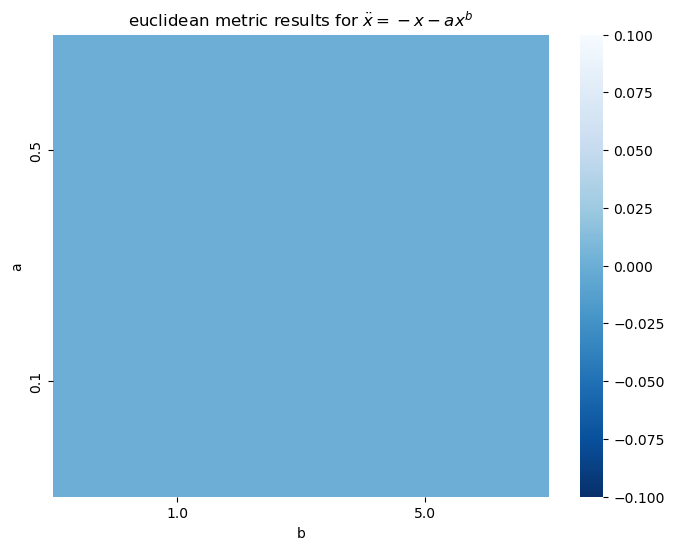

In [37]:
heatmap_plotter(grid1)